# Demo — From Regression to Deep Learning

## Setup
If packages are missing, uncomment the pip installs.

In [89]:
# !pip install -q torch matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


Set seed for reproducibility


In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Make a 2D dataset
We use `make_circles` if available; otherwise a lightweight spiral generator.

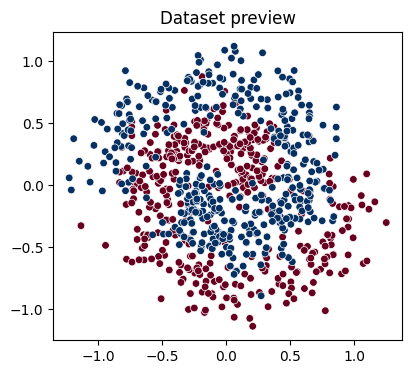

In [91]:
def make_spiral(n=500, noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    n2 = n // 2
    t = np.linspace(0, 2*np.pi, n2)
    r = np.linspace(0.2, 1.0, n2)
    x1 = np.c_[r*np.cos(t), r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    x2 = np.c_[-r*np.cos(t), -r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    Xs = np.vstack([x1, x2]).astype('float32')
    ys = np.r_[np.zeros(n2), np.ones(n2)].astype('float32')
    return Xs, ys

X, y = make_spiral(n=800, noise=0.15, seed=0)

plt.figure(figsize=(4.5,4))
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', s=30, edgecolor='white', linewidth=0.5)
plt.title('Dataset preview')
plt.show()


## Build and train a small network
Two hidden layers with ReLU and a sigmoid output for binary classification.

In [92]:
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8 * len(X))
train_idx, val_idx = idx[:split], idx[split:]
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]


In [93]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train).unsqueeze(1)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val).unsqueeze(1)

In [94]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid(),
)

In [95]:
model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

train_losses = []
val_losses = []

for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

model.eval()
with torch.no_grad():
    val_probs = model(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()
float(val_acc)


0.862500011920929

## Training and validation loss
Track how the model improves over epochs.


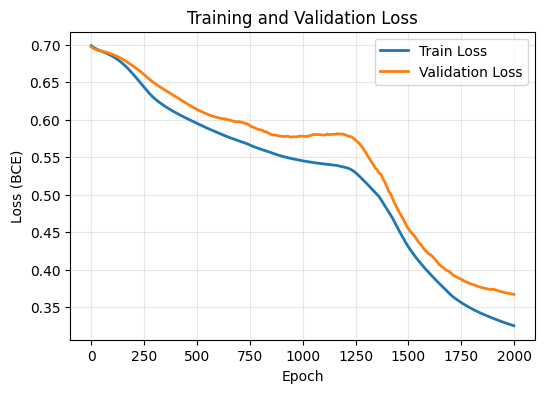

In [97]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Plot decision regions
Compare model predictions across a mesh grid with the data points.

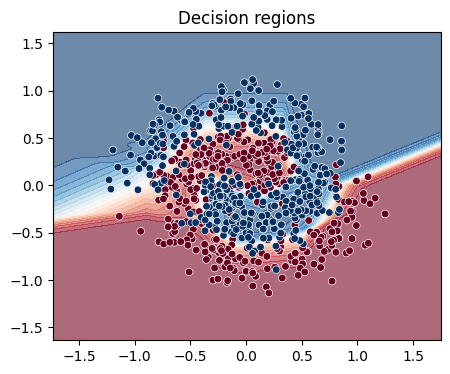

In [98]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
model.eval()
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
cs = plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Decision regions')
plt.show()


# Generate Spiral Datasets of Different Complexity and Visualize



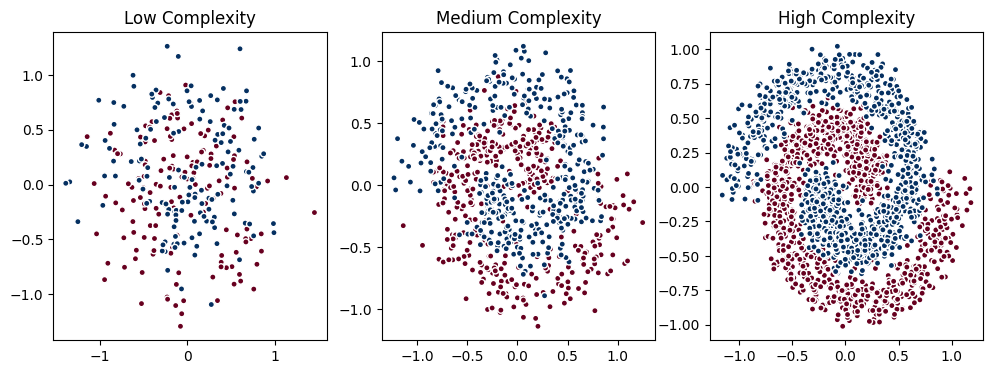

In [ ]:
# Spiral dataset generator
def make_spiral(n=500, noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    n2 = n // 2
    t = np.linspace(0, 2*np.pi, n2)
    r = np.linspace(0.2, 1.0, n2)
    x1 = np.c_[r*np.cos(t), r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    x2 = np.c_[-r*np.cos(t), -r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    Xs = np.vstack([x1, x2]).astype('float32')
    ys = np.r_[np.zeros(n2), np.ones(n2)].astype('float32')
    return Xs, ys

# Different complexity datasets
datasets = {
    "Low": make_spiral(n=300, noise=0.25),
    "Medium": make_spiral(n=800, noise=0.15),
    "High": make_spiral(n=2000, noise=0.10)
}

# Show scatter plots
plt.figure(figsize=(12,4))
for i, (name, (X, y)) in enumerate(datasets.items()):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', s=20)
    plt.title(f"{name} Complexity")
plt.show()


# Prepare Data: Split into Train and Validation Sets


In [100]:
def prepare_data(X, y, test_ratio=0.2):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    split = int(len(X)*(1-test_ratio))
    train_idx, val_idx = idx[:split], idx[split:]
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    
    # Convert to Torch tensors
    X_train_t = torch.from_numpy(X_train)
    y_train_t = torch.from_numpy(y_train).unsqueeze(1)
    X_val_t = torch.from_numpy(X_val)
    y_val_t = torch.from_numpy(y_val).unsqueeze(1)
    
    return X_train_t, y_train_t, X_val_t, y_val_t


# Train Models on Different Complexity Datasets and Store Results


In [101]:
results = {}

for name, (X, y) in datasets.items():
    X_train_t, y_train_t, X_val_t, y_val_t = prepare_data(X, y)
    model = build_small_model()
    train_losses, val_losses, val_acc = train_model(model, X_train_t, y_train_t, X_val_t, y_val_t, epochs=1500)
    results[name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_acc": val_acc,
        "model": model,
        "X": X,
        "y": y
    }
    print(f"{name} Complexity → Validation Accuracy: {val_acc:.3f}")


Low Complexity → Validation Accuracy: 0.683
Medium Complexity → Validation Accuracy: 0.875
High Complexity → Validation Accuracy: 0.957


# Visualize Decision Boundaries for All Datasets


Low Complexity


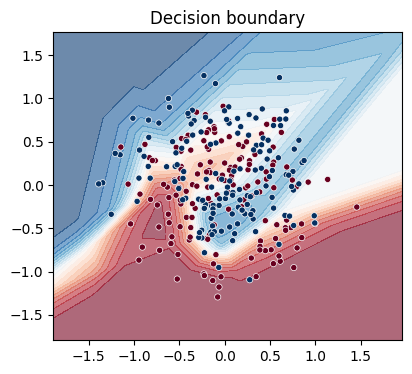

Medium Complexity


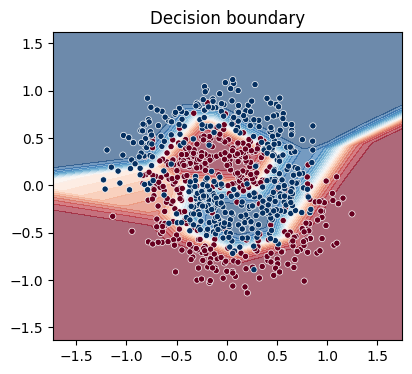

High Complexity


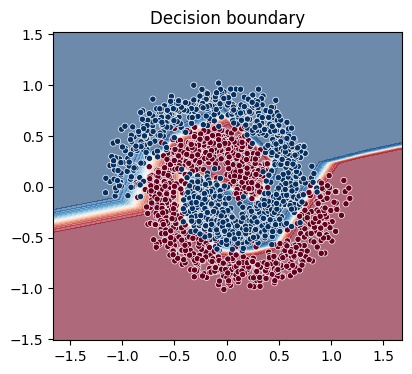

In [102]:
def plot_decision_boundary(model, X, y):
    xx, yy = np.meshgrid(
        np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
        np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
    grid_t = torch.from_numpy(grid)
    
    model.eval()
    with torch.no_grad():
        probs = model(grid_t).numpy().reshape(xx.shape)
    
    plt.figure(figsize=(4.5,4))
    plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=20)
    plt.title('Decision boundary')
    plt.show()

for name in results:
    print(f"{name} Complexity")
    plot_decision_boundary(results[name]["model"], results[name]["X"], results[name]["y"])


# Function to Build Neural Network with Custom Hidden Layers



In [104]:
def build_model(layers):
    """
    layers: list, e.g., [8] => 1 hidden layer with 8 neurons
                           [8,8] => 2 hidden layers with 8 neurons each
    """
    model_layers = []
    input_dim = 2
    for h in layers:
        model_layers.append(nn.Linear(input_dim, h))
        model_layers.append(nn.ReLU())
        input_dim = h
    model_layers.append(nn.Linear(input_dim, 1))
    model_layers.append(nn.Sigmoid())
    
    return nn.Sequential(*model_layers)


Different Network Architectures to Experiment With.


In [105]:
architectures = {
    "1 hidden layer [4]": [4],
    "1 hidden layer [8]": [8],
    "1 hidden layer [16]": [16],
    "2 hidden layers [8,8]": [8,8],
    "2 hidden layers [16,16]": [16,16],
    "3 hidden layers [16,16,16]": [16,16,16],
    "3 hidden layers [32,32,32]": [32,32,32]
}


# Train and Evaluate Different Architectures



In [106]:
results_hidden = {}

for name, layers in architectures.items():
    print(f"Training {name}...")
    model = build_model(layers)
    train_losses, val_losses, val_acc = train_model(model, X_train_t, y_train_t, X_val_t, y_val_t, epochs=1500)
    
    results_hidden[name] = {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_acc": val_acc
    }
    
    print(f"{name} → Validation Accuracy: {val_acc:.3f}")


Training 1 hidden layer [4]...
1 hidden layer [4] → Validation Accuracy: 0.600
Training 1 hidden layer [8]...
1 hidden layer [8] → Validation Accuracy: 0.631
Training 1 hidden layer [16]...
1 hidden layer [16] → Validation Accuracy: 0.837
Training 2 hidden layers [8,8]...
2 hidden layers [8,8] → Validation Accuracy: 0.812
Training 2 hidden layers [16,16]...
2 hidden layers [16,16] → Validation Accuracy: 0.863
Training 3 hidden layers [16,16,16]...
3 hidden layers [16,16,16] → Validation Accuracy: 0.837
Training 3 hidden layers [32,32,32]...
3 hidden layers [32,32,32] → Validation Accuracy: 0.844


# Plot Training and Validation Loss 


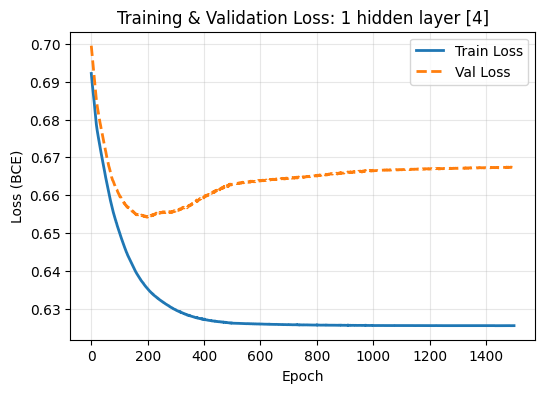

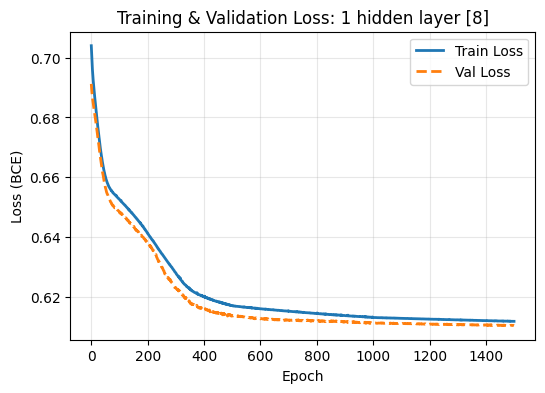

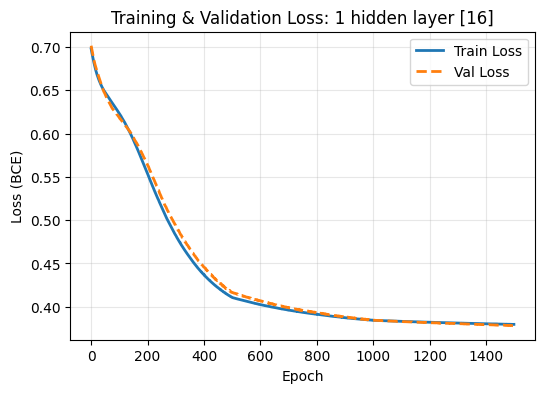

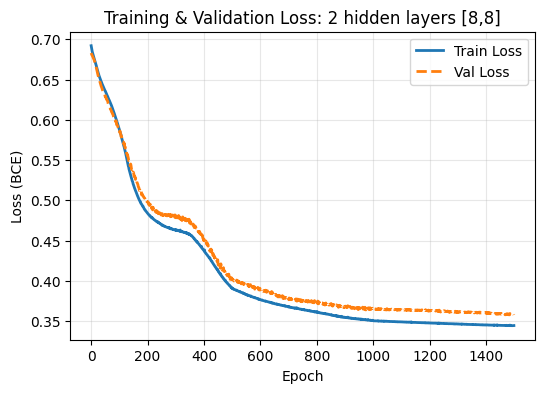

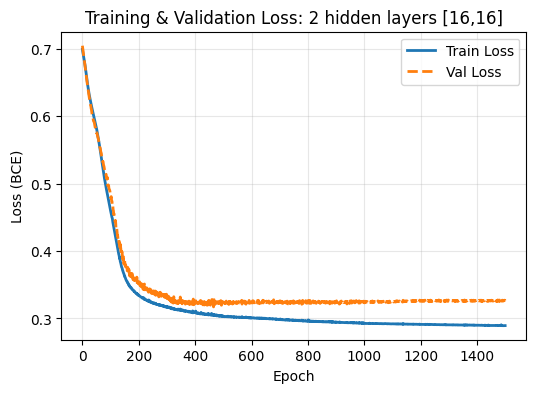

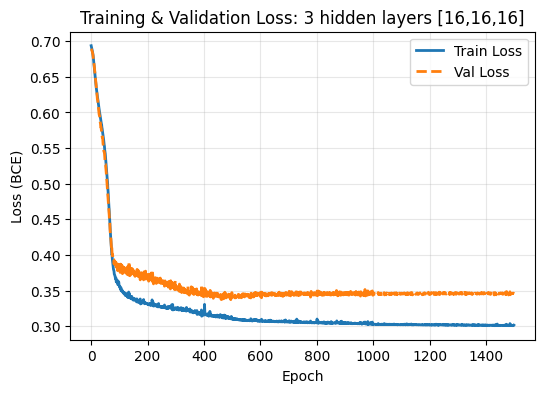

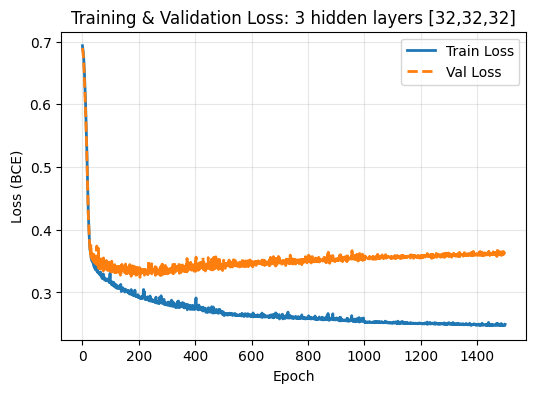

In [115]:
for name, res in results_hidden.items():
    plt.figure(figsize=(6,4))
    plt.plot(res["train_losses"], label="Train Loss", linewidth=2)
    plt.plot(res["val_losses"], label="Val Loss", linestyle='--', linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (BCE)")
    plt.title(f"Training & Validation Loss: {name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



# Decision Boundaries for Each Architecture



1 hidden layer [4]


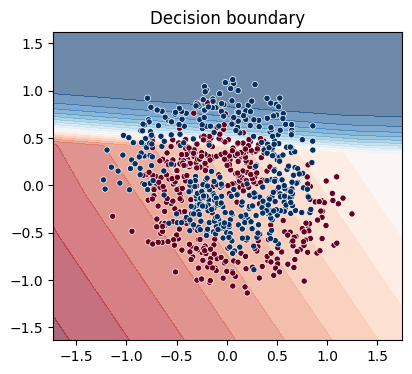

1 hidden layer [8]


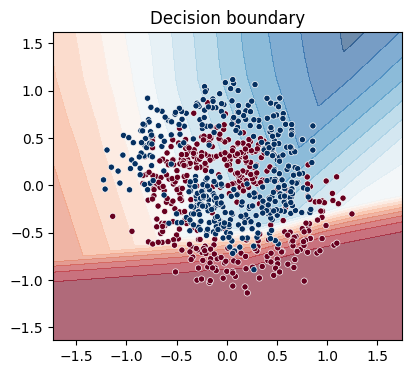

1 hidden layer [16]


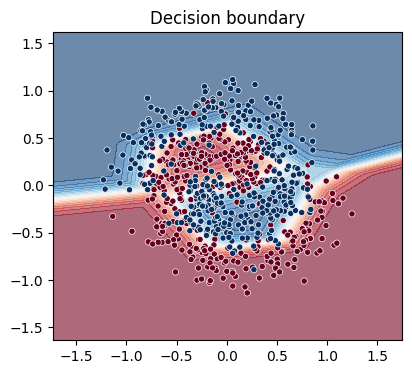

2 hidden layers [8,8]


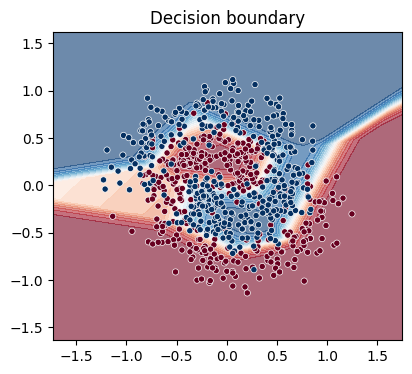

2 hidden layers [16,16]


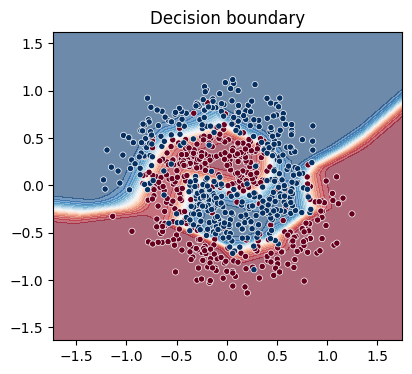

3 hidden layers [16,16,16]


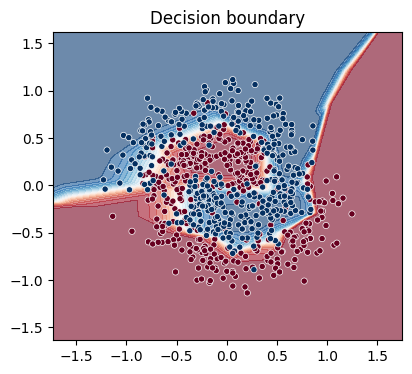

3 hidden layers [32,32,32]


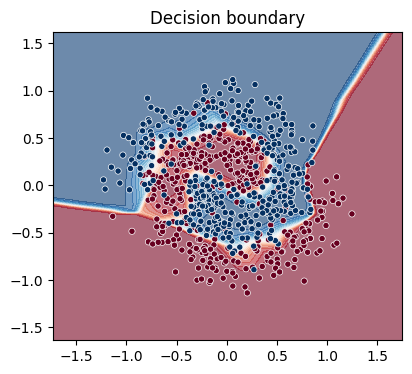

In [116]:
for name, res in results_hidden.items():
    print(name)
    plot_decision_boundary(res["model"], X, y)


Width Study — Different Layer Widths


In [117]:
width_configs = {
    "[4, 4]": [4, 4],
    "[16, 16]": [16, 16],
    "[64, 64]": [64, 64],
    "[128, 128]": [128, 128],
    "[256, 256]": [256, 256],
}


# Training Results for Different Width Configurations


In [118]:
results_width = {}

for name, layers in width_configs.items():
    print(f"Training {name}...")
    model = build_model(layers)
    train_losses, val_losses, val_acc = train_model(model, X_train_t, y_train_t, X_val_t, y_val_t, epochs=1500)

    results_width[name] = {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_acc": val_acc
    }
    
    print(f"{name} → Validation Accuracy: {val_acc:.3f}")


Training [4, 4]...


[4, 4] → Validation Accuracy: 0.788
Training [16, 16]...
[16, 16] → Validation Accuracy: 0.863
Training [64, 64]...
[64, 64] → Validation Accuracy: 0.850
Training [128, 128]...
[128, 128] → Validation Accuracy: 0.850
Training [256, 256]...
[256, 256] → Validation Accuracy: 0.825


# Width Study — Training and Validation Loss Curves


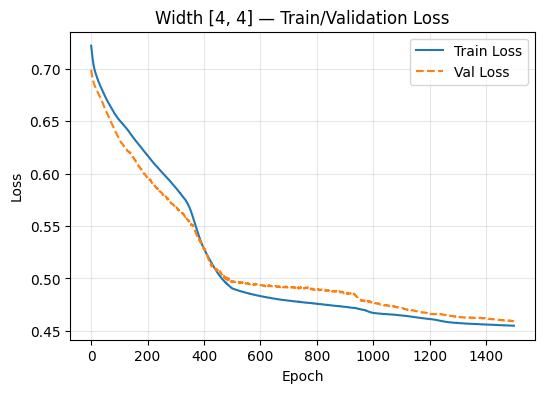

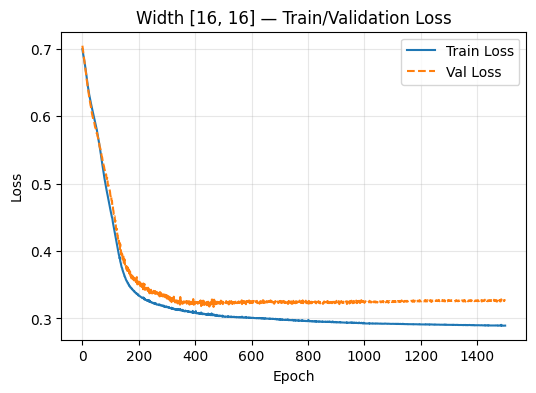

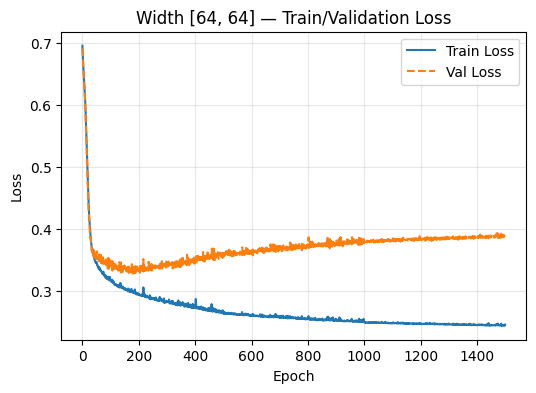

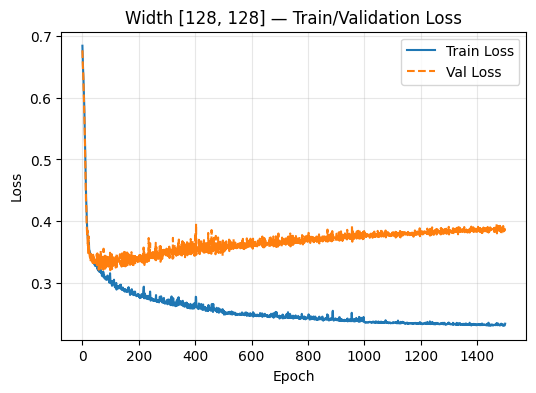

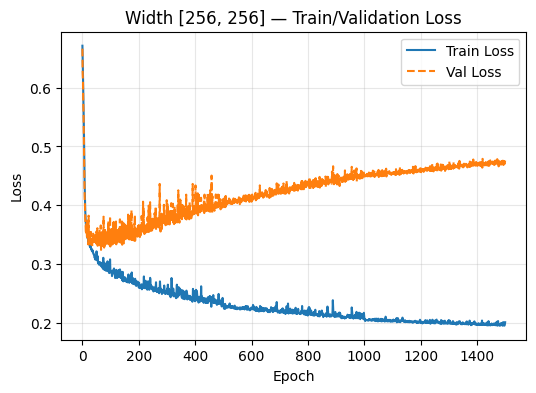

In [123]:
for name, res in results_width.items():
    plt.figure(figsize=(6,4))
    plt.plot(res["train_losses"], label="Train Loss")
    plt.plot(res["val_losses"], linestyle="--", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Width {name} — Train/Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# Width Study — Decision Boundaries


Decision boundary for [4, 4]


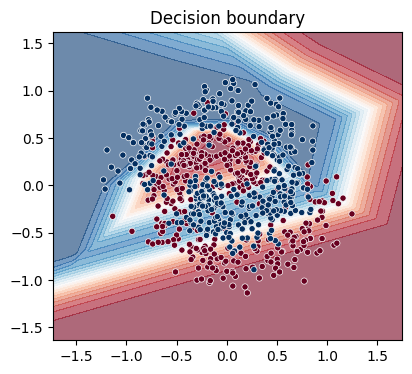

Decision boundary for [16, 16]


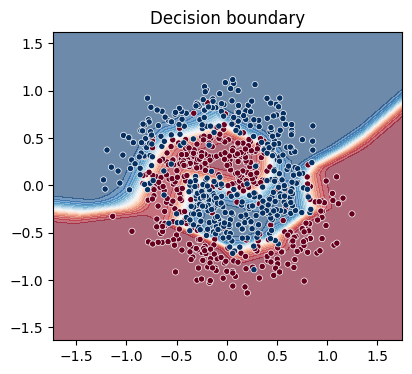

Decision boundary for [64, 64]


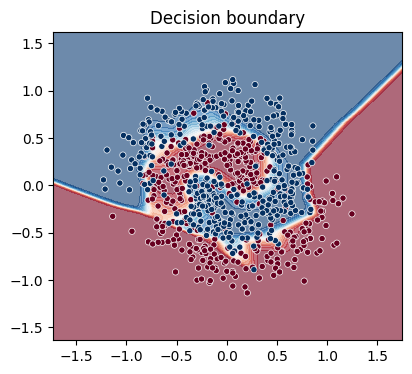

Decision boundary for [128, 128]


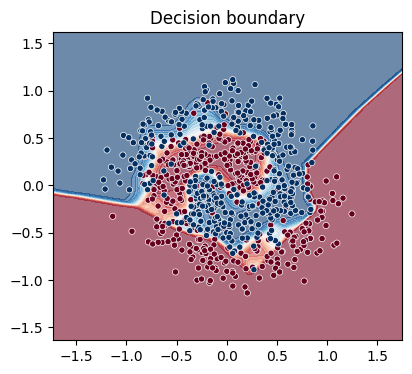

Decision boundary for [256, 256]


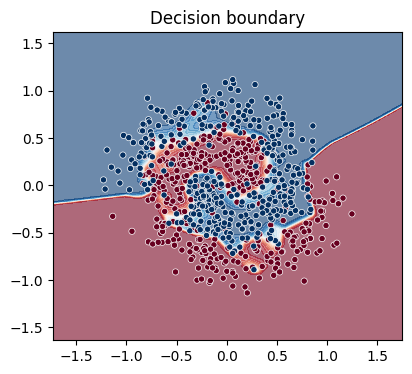

In [124]:
for name, res in results_width.items():
    print(f"Decision boundary for {name}")
    plot_decision_boundary(res["model"], X, y)


# Worst Hidden Layer Architecture


Worst Hidden Layer Model: 1 hidden layer [4] → Accuracy: 0.6


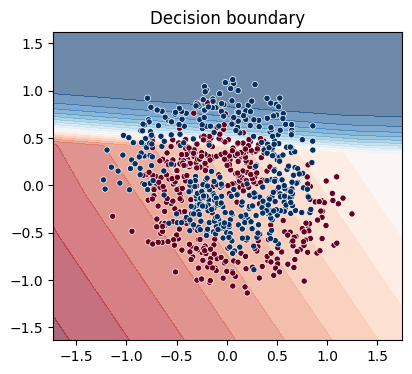

In [ ]:
worst_arch = None
worst_acc = 1.0  

for name, res in results_hidden.items():
    acc = res["val_acc"]
    if acc < worst_acc:
        worst_acc = acc
        worst_arch = name

print("Worst Hidden Layer Model:", worst_arch, "→ Accuracy:", round(worst_acc, 3))
plot_decision_boundary(results_hidden[worst_arch]["model"], X, y)

# Best Maximal Hidden Layer Models


Best Maximal Model: 2 hidden layers [16,16] → Accuracy: 0.863


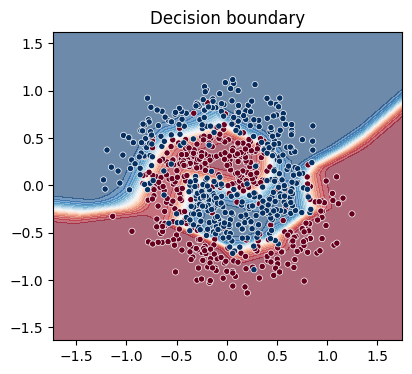

In [126]:
# Find best and worst maximal models (only print best & worst)
best_arch = None
best_acc = 0
worst_arch = None
worst_acc = 1.0

for name, res in results_hidden.items():
    acc = res["val_acc"]
    if acc > best_acc:
        best_acc = acc
        best_arch = name
    if acc < worst_acc:
        worst_acc = acc
        worst_arch = name

print("Best Maximal Model:", best_arch, "→ Accuracy:", round(best_acc, 3))

# Plot decision boundary for the best maximal model
plot_decision_boundary(results_hidden[best_arch]["model"], X, y)

